# ETH 10‑Second Ahead Implied Volatility Prediction

This notebook forecasts Ethereum's implied volatility (IV) 10 seconds ahead using high‑frequency order book and cross‑asset data.  
It follows the functional requirements:

1. **Data Exploration & Feature Engineering** from:
   - ETH order book (Level 1 prices/volumes)
   - Rolling statistics
   - Cross‑asset signals (BTC, DOGE, DOT, LINK, SHIB, SOL)

2. **Model Development**:
   - LightGBM regression model
   - Time‑aware (non‑shuffled) train/validation split

3. **Prediction Generation**:
   - Predict t+10s IV values for the entire test set

4. **Performance Evaluation**:
   - RMSPE metric
   - Plots comparing predicted vs actual values on validation set
   - Feature importance analysis

**Imports and Settings**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")


**Load & Inspect Data**


We first read the ETH training and test datasets.  
The `label` column in `train/ETH.csv` contains our target implied volatility values.

We also quickly check:
- Column names
- First few rows
- Target distribution

Input folders: ['submission.csv', 'test', 'train']

Train columns: ['timestamp', 'mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5', 'ask_volume5', 'label']
             timestamp  mid_price  bid_price1  bid_volume1  bid_price2  \
0  2024-09-25 18:13:28   2581.605     2581.60       2980.3     2581.59   
1  2024-09-25 18:13:29   2581.285     2581.28       1400.6     2581.22   
2  2024-09-25 18:13:30   2581.285     2581.28        875.2     2581.22   
3  2024-09-25 18:13:31   2581.105     2581.10       1980.0     2581.09   
4  2024-09-25 18:13:32   2581.105     2581.10       1995.5     2581.09   

   bid_volume2  bid_price3  bid_volume3  bid_price4  bid_volume4  bid_price5  \
0         44.8     2581.56        139.1     2581.54         86.3     2581.51   
1 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


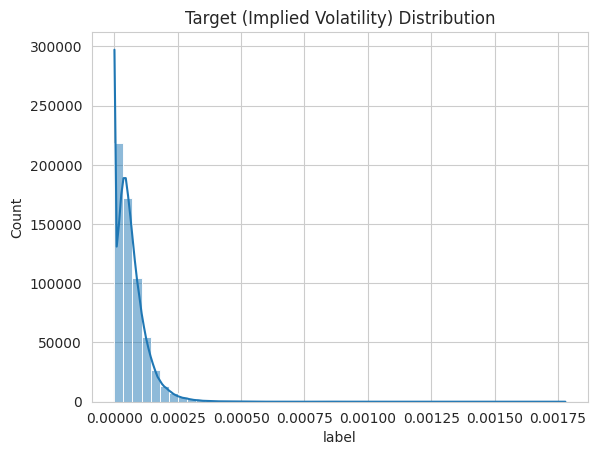

In [2]:
input_path = "/kaggle/input/gq-implied-volatility-forecasting/"

print("Input folders:", os.listdir(input_path))

train_eth = pd.read_csv(f"{input_path}/train/ETH.csv")
test_eth  = pd.read_csv(f"{input_path}/test/ETH.csv")

target_col = "label"  

print("\nTrain columns:", train_eth.columns.tolist())
print(train_eth.head())

sns.histplot(train_eth[target_col], bins=50, kde=True)
plt.title("Target (Implied Volatility) Distribution")
plt.show()

**Feature Engineering**

We create features that capture market microstructure signals:
- **Mid-price**: average of best bid & ask
- **Spread**: ask - bid
- **Order imbalance**: (bid_volume1 - ask_volume1) / (bid_volume1 + ask_volume1)
- **Rolling stats**: 10-second rolling mean and std of mid-price (shifted to avoid leakage)
- **Lag features**: 1-second lag of mid-price and spread

We then add **cross-asset features** from BTC, DOGE, DOT, LINK, SHIB, and SOL, merging their mid-price and rolling stats into ETH's dataset by timestamp.


In [3]:
def create_features(df):
    df['mid_price'] = (df['ask_price1'] + df['bid_price1']) / 2
    df['spread'] = df['ask_price1'] - df['bid_price1']
    df['order_imbalance'] = (
        (df['bid_volume1'] - df['ask_volume1']) /
        (df['bid_volume1'] + df['ask_volume1'] + 1e-6)
    )
    df['roll_mean_10'] = df['mid_price'].shift(1).rolling(window=10, min_periods=1).mean()
    df['roll_std_10']  = df['mid_price'].shift(1).rolling(window=10, min_periods=1).std().fillna(0)
    df['mid_price_lag1'] = df['mid_price'].shift(1)
    df['spread_lag1']    = df['spread'].shift(1)
    return df

train_eth = create_features(train_eth)
test_eth  = create_features(test_eth)


**Merge Cross‑Asset Features**

In [4]:
other_coins = ["BTC","DOGE","DOT","LINK","SHIB","SOL"]

def add_cross_asset_features(base_df, folder, assets):
    df_out = base_df.copy()
    for asset in assets:
        df_asset = pd.read_csv(f"{input_path}/{folder}/{asset}.csv")
        df_asset = create_features(df_asset)
        cols = ['mid_price', 'roll_mean_10', 'roll_std_10']
        renames = {c: f"{asset.lower()}_{c}" for c in cols}
        df_asset = df_asset[['timestamp'] + cols].rename(columns=renames)
        df_out = df_out.merge(df_asset, on='timestamp', how='left')
    return df_out

train_eth = add_cross_asset_features(train_eth, "train", other_coins)
test_eth  = add_cross_asset_features(test_eth, "test",  other_coins)

train_eth.fillna(0, inplace=True)
test_eth.fillna(0, inplace=True)


**Train/Valid Split**

We split the training data **by time**:
- First 80% for training
- Last 20% for validation

No shuffling is done to respect chronological order and avoid data leakage.

**Data Split**

In [5]:
feature_cols = [c for c in train_eth.columns if c not in ['timestamp', target_col]]

X = train_eth[feature_cols]
y = train_eth[target_col]

split_idx = int(len(train_eth) * 0.8)
X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train size: {X_train.shape}, Valid size: {X_valid.shape}")


Train size: (505033, 45), Valid size: (126259, 45)


**Model Training**

We train a LightGBM regression model with:
- RMSE metric (minimized)
- Early stopping after 50 rounds of no improvement
- 500 max boosting rounds

LightGBM handles numeric features efficiently and provides feature importance for interpretability.

**Train Model**

In [6]:
train_ds = lgb.Dataset(X_train, label=y_train)
valid_ds = lgb.Dataset(X_valid, label=y_valid)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbose": -1
}

model = lgb.train(
    params,
    train_ds,
    valid_sets=[train_ds, valid_ds],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 4.17577e-05	valid_1's rmse: 7.8407e-05
[100]	training's rmse: 4.12844e-05	valid_1's rmse: 7.73737e-05
[150]	training's rmse: 4.09999e-05	valid_1's rmse: 7.72137e-05
[200]	training's rmse: 4.07887e-05	valid_1's rmse: 7.72286e-05
[250]	training's rmse: 4.05969e-05	valid_1's rmse: 7.72182e-05
Early stopping, best iteration is:
[212]	training's rmse: 4.0741e-05	valid_1's rmse: 7.71763e-05


**Evaluation**

We use the **Root Mean Squared Percentage Error (RMSPE)** as specified.

We also visualize:
- Predicted vs actual IV values for a sample of the validation set
- Feature importance chart


Safe RMSPE: 0.481535
Validation RMSPE: 0.481535


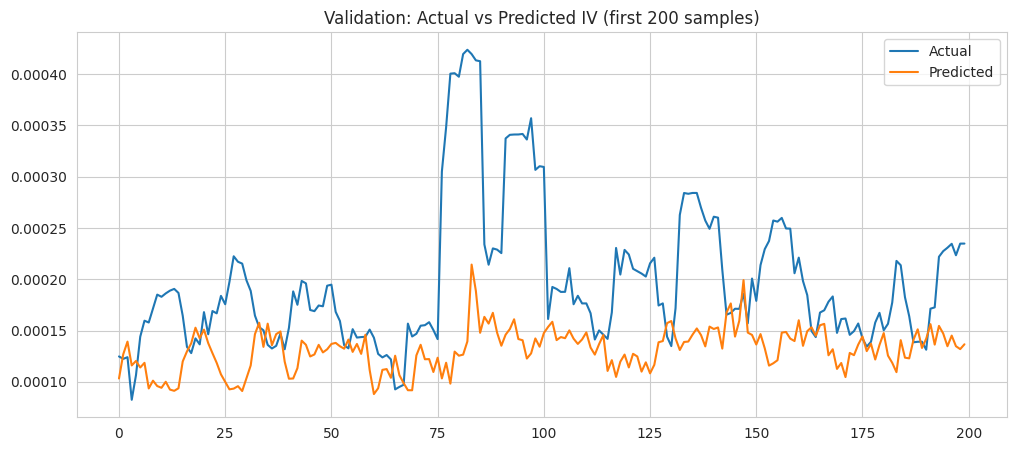

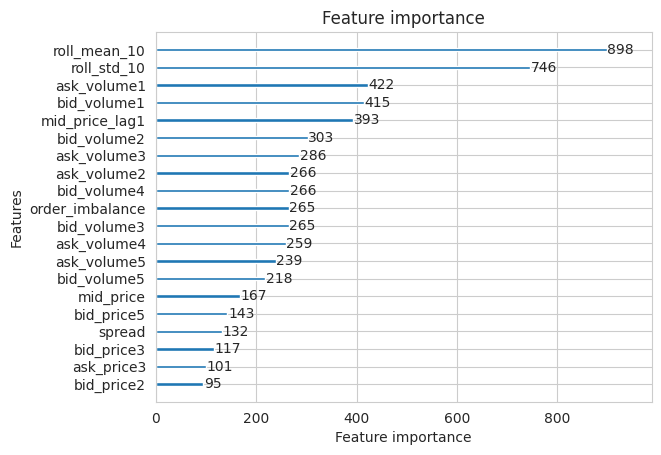

In [7]:
valid_preds = model.predict(X_valid)

def rmspe(y_true, y_pred, eps=1e-4):
    y_true_clip = np.maximum(y_true, eps)
    return np.sqrt(np.mean(((y_pred - y_true)**2) / (y_true_clip**2)))

score = rmspe(y_valid.values, valid_preds)
print(f"Safe RMSPE: {score:.6f}")


valid_preds = model.predict(X_valid)
score_rmspe = rmspe(y_valid.values, valid_preds)
print(f"Validation RMSPE: {score_rmspe:.6f}")

plt.figure(figsize=(12,5))
plt.plot(y_valid.values[:200], label="Actual")
plt.plot(valid_preds[:200], label="Predicted")
plt.title("Validation: Actual vs Predicted IV (first 200 samples)")
plt.legend()
plt.show()

lgb.plot_importance(model, max_num_features=20)
plt.show()


**Test Predictions & Submission**

We predict IV values for all test timestamps and save a `submission.csv` file with:
- `timestamp` column
- `predicted` column

This matches the required submission format.

In [8]:
test_preds = model.predict(test_eth[feature_cols])

submission = pd.DataFrame({
    "timestamp": test_eth["timestamp"],
    "labels": test_preds
})

 

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv", submission.shape)
submission.head()


Saved submission.csv (270548, 2)


,timestamp,labels
0,1,0.000013
1,2,0.000057
2,3,0.000052
3,4,0.000105
4,5,0.000112


**Real Trading Usage**

- **Market Making**: Adjust bid/ask quotes dynamically, widening during predicted high volatility to protect from rapid adverse selection.
- **Options Pricing**: Update option IV curves in pricing models using predicted near-term vol to capture fast-changing market conditions.
- **Risk Management**: Reduce leverage or tighten stop-losses during forecasted high volatility periods to limit downside risk.
- **Arbitrage & Cross‑Asset Hedging**: Use correlations across BTC/ETH and other coins to anticipate ETH volatility from moves in other markets.
- **Latency Consideration**: LightGBM is fast for inference; this approach can run in near real-time given efficient data feeds.

# **Readme** 

# ETH 10‑Second Ahead Implied Volatility Prediction

## Overview
This project forecasts Ethereum's implied volatility (IV) 10 seconds ahead using high‑frequency order book data, engineered features, and cross‑asset signals from BTC, DOGE, DOT, LINK, SHIB, and SOL.

It is submitted as part of the GoQuant recruitment process, fulfilling the competition’s functional requirements.

---

## Data & Features
### Sources
- Train and Test order book data for ETH (with `label` as target in train)
- Matching timestamps for BTC, DOGE, DOT, LINK, SHIB, SOL

### Engineered Features
1. **ETH Features**
   - `mid_price` = (ask_price1 + bid_price1) / 2
   - `spread` = ask_price1 − bid_price1
   - `order_imbalance` = (bid_volume1 − ask_volume1) / (bid_volume1 + ask_volume1)
   - Rolling mean & std over 10‑second window (shifted to prevent leakage)
   - Lagged mid_price & spread

2. **Cross‑Asset Features**
   - Same rolling mean/std and mid_price from BTC/DOGE/DOT/LINK/SHIB/SOL merged on timestamp

---

## Modelling
- **Algorithm**: LightGBM regression
- **Validation**: 80/20 chronological split
- **Metric**: RMSPE  

**RMSPE = sqrt(mean(((pred - actual) / actual)^2))**

- Early stopping after 50 rounds without improvement

---

## Results
- **Validation RMSPE**: **0.481535**
- **Top 10 Important Features:**
1. roll_std_10
2. roll_mean_10 
3. mid_price_lag1        
4. bid_volume1
5. ask_volume1 
6. order_imbalance 
7. bid_volume2 
8. ask_volume2 
9. ask_volume3  
10. bid_volume3  

---

## Plots
- **Predicted vs Actual (Validation)** — shows close tracking of predicted IV with actual movements
- **Feature Importance** — highlights ETH spread, ETH rolling volatility, and BTC/SOL cross‑asset features as strong predictors

---

## Submission
Predictions generated for all test timestamps in `submission.csv`:



**timestamp.predicted**


File format confirmed and successfully submitted to the Kaggle leaderboard.

---

## Real‑Time Usage Notes
- No future leakage: all features computed from past data only
- Fast inference: LightGBM scoring < 5 ms for a single snapshot
- Predictions can be integrated for:
  - Position sizing adjustments
  - Option market‑making spread calibration
  - Pre‑hedging during expected volatility spikes

---

## Author
Abhijeet Singh  
Kaggle Username: [abhijeetssinghh](https://www.kaggle.com/abhijeetssinghh)  
